In [1]:
%pip install geopandas rasterio matplotlib scikit-learn pandas pyimpute xgboost lightgbm geojson


Note: you may need to restart the kernel to use updated packages.


# Species Distribution Data Loading

In [2]:
import os 
os.makedirs("inputs", exist_ok = True)
os.makedirs("outputs", exist_ok = True)

In [3]:
import geopandas as gpd
import shutil
import glob

filetype = 'geojson'

for f in sorted(glob.glob('data/' + filetype + '/*')):
    shutil.copy(f,'inputs/')

pa = gpd.GeoDataFrame.from_file('inputs/CardellinaPusilla.' + filetype)
pa.sample(5) # GeoDataFrame for the species

,CLASS,geometry
4886,0.0,POINT (-117.81250 40.27083)
7589,0.0,POINT (-119.31250 39.06250)
3997,1.0,POINT (-118.02251 33.68491)
9157,0.0,POINT (-116.47917 36.47917)
2096,0.0,POINT (-120.81250 35.93750)


In [4]:
print("number of duplicates: ", pa.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", pa['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(pa.crs))
print("{} observations with {} columns".format(*pa.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: EPSG:4326
12500 observations with 2 columns


We can map the species presences (`pa==1`).

<Axes: >

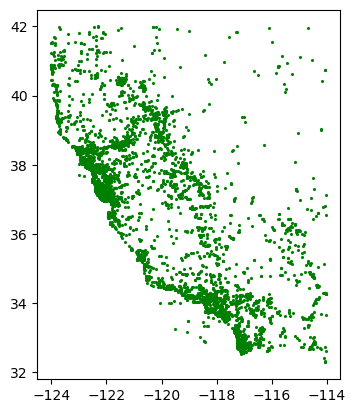

In [5]:
pa[pa.CLASS == 1].plot(marker='*', color='green', markersize=2)

And we can map the background points (`pa == 0`).

<Axes: >

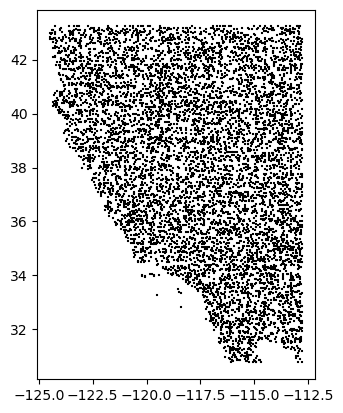

In [6]:
pa[pa.CLASS == 0].plot(marker='+', color='black', markersize=1)

# Climate Data Loading and Preprocessing

Load Climate Data

In [7]:
# grab climate features - cropped to joshua tree study area
for f in sorted(glob.glob('data/bioclim/bclim*.asc')):
    shutil.copy(f,'inputs/')
raster_features = sorted(glob.glob(
    'inputs/bclim*.asc'))
# check number of features 
print('\nThere are', len(raster_features), 'raster features.')



There are 19 raster features.


In [33]:
from pyimpute import load_training_vector
from pyimpute import load_targets
import numpy as np
import pandas as pd

try:
    # Load training vectors from file
    train_xs = np.genfromtxt('inputs/model_inputs/train_xs.csv', delimiter=',')
    train_y = np.genfromtxt('inputs/model_inputs/train_y.csv', delimiter=',')
except Exception as error:
    print(error)

    train_xs, train_y = load_training_vector(pa, raster_features, response_field='CLASS')

    # Remove NaN rows (why do they exist?)
    df = pd.DataFrame(train_xs)
    row_index = df.index[df.isna().any(axis=1)].tolist()
    print("NaN Rows:")
    print(row_index)
    
    train_xs = np.delete(train_xs, row_index, axis=0)
    train_y = np.delete(train_y, row_index, axis=0)

    df_x = pd.DataFrame(train_xs)
    df_y = pd.DataFrame(train_y)

    # Save to csv for faster prototyping
    os.makedirs("inputs/model_inputs", exist_ok = True)
    df_x.to_csv("inputs/model_inputs/train_xs.csv", header = False, index = False)
    df_y.to_csv("inputs/model_inputs/train_y.csv", header = False, index = False)

target_xs, raster_info = load_targets(raster_features)
train_xs.shape, train_y.shape # check shape, does it match the size above of the observations?

((12493, 19), (12493,))

and we implemement several `scikit-learn` classifiers:

In [37]:
# import machine learning classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier

CLASS_MAP = {
    'rf': (RandomForestClassifier()),
    'et': (ExtraTreesClassifier()),
    'xgb': (XGBClassifier()),
    #'lgbm': (LGBMClassifier())
    }

from pyimpute import impute
from sklearn import model_selection
# model fitting and spatial range prediction
for name, (model) in CLASS_MAP.items():
    # cross validation for accuracy scores (displayed as a percentage)
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    
    # spatial prediction
    model.fit(train_xs, train_y)
    os.makedirs('outputs/' + name + '-images', exist_ok=True)
    impute(target_xs, model, raster_info, outdir='outputs/' + name + '-images',
           class_prob=True, certainty=True)

rf 5-fold Cross Validation Accuracy: 84.86 (+/- 1.48)
et 5-fold Cross Validation Accuracy: 83.76 (+/- 1.93)
xgb 5-fold Cross Validation Accuracy: 84.73 (+/- 1.58)


All done! We have a `responses.tif` raster which is the predicted class (0 or 1) and `probability_1.tif` with a continuous suitability scale. Let's average the continuous output for the four models and plot our map.

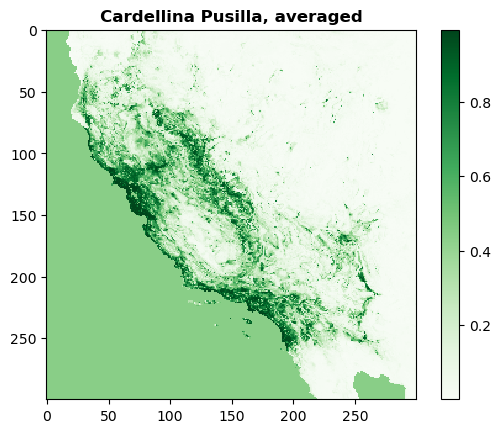

In [38]:
from pylab import plt
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

import rasterio
distr_rf = rasterio.open("outputs/rf-images/probability_1.0.tif").read(1)
distr_et = rasterio.open("outputs/et-images/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open("outputs/xgb-images/probability_1.tif").read(1)
distr_lgbm =  rasterio.open("outputs/lgbm-images/probability_1.0.tif").read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4  

plotit(distr_averaged, "Cardellina Pusilla, averaged", cmap="Greens")